# Artificial Intelligence Nanodegree
## Machine Translation Project
In this notebook, sections that end with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully!

## Introduction
In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. Your completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - You'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [1]:
import helper


# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [2]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [3]:
import collections


english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [4]:
import project_tests as tests
from keras.preprocessing.text import Tokenizer


def tokenize(x):
    """
    Tokenize x
    
    ref: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
    
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    # fit the tokenizer on the documents
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    return sequences, tokenizer

tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

Using TensorFlow backend.


{'sentence': 21, 'jove': 11, 'the': 1, 'fox': 5, 'a': 3, 'of': 14, 'prize': 17, 'over': 7, 'dog': 9, 'this': 18, 'won': 16, 'by': 10, 'lexicography': 15, 'lazy': 8, 'brown': 4, 'quick': 2, 'my': 12, 'jumps': 6, 'short': 20, 'is': 19, 'study': 13}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [10]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences


def pad(x, length=None):
    """
    Pad x
    
    ref: https://keras.io/preprocessing/sequence/
    
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    return pad_sequences(x, maxlen=length, padding="post")
tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [6]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)

print('Data Preprocessed')


Data Preprocessed


In [17]:
import matplotlib.pyplot as plt

# 
def visualize_train(model_hist):
    """
    Provides a visualization of the training process
    
    ref: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    """
    # summarize history for accuracy
    plt.plot(model_hist.history['acc'])
    plt.plot(model_hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(model_hist.history['loss'])
    plt.plot(model_hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [12]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [130]:
from keras.layers import GRU, Input, Dense, TimeDistributed
from keras.models import Model
from keras.layers import Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy


def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    
    ref: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
    ref: https://keras.io/layers/wrappers/
    ref: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/
    ref: https://keras.io/layers/embeddings/
    
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    # hyperparams
    rnn_dim = 64
    learning_rate = 0.01
    
    # model
    model_input = Input(shape=(input_shape[1], input_shape[2]))
    rnn_outputs = GRU(rnn_dim, return_sequences=True)(model_input)
    model_output = TimeDistributed(Dense(french_vocab_size, activation='softmax'))(rnn_outputs)
    model = Model(model_input, model_output)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
    
tests.test_simple_model(simple_model)

In [131]:
# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index),
    len(french_tokenizer.word_index))

simple_rnn_model.summary()

hist = simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=2048, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 21, 1)             0         
_________________________________________________________________
gru_100 (GRU)                (None, 21, 64)            12672     
_________________________________________________________________
time_distributed_74 (TimeDis (None, 21, 344)           22360     
Total params: 35,032
Trainable params: 35,032
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 8s - loss: 2.7306 - acc: 0.4536 - val_loss: nan - val_acc: 0.5110
Epoch 2/10
110288/110288 [==============================] - 5s - loss: 1.8904 - acc: 0.5535 - val_loss: nan - val_acc: 0.5796
Epoch 3/10
110288/110288 [==============================] - 5s - loss: 1.6294 - acc: 0.5896 - val_l

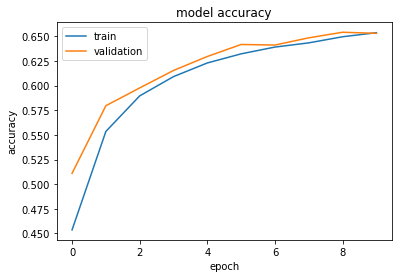

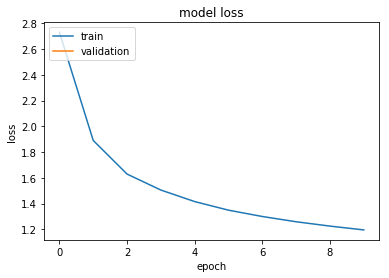

new jersey est parfois calme en l' et il est est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [133]:
visualize_train(hist)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

In [134]:
from keras.layers.embeddings import Embedding

def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    
    ref: https://keras.io/layers/embeddings/
    
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    
    # hyperparams: 
    embed_dim = 100
    rnn_dim = 64
    learning_rate = 0.01
    
    # model
    model_input = Input(shape=(input_shape[1],))
    embedding_layer = Embedding(english_vocab_size, embed_dim, input_length=output_sequence_length)
    rnn_input = embedding_layer(model_input)
    rnn_output = GRU(rnn_dim, return_sequences=True)(rnn_input)
    tddens_layer = TimeDistributed(Dense(french_vocab_size, activation='softmax'))
    model_output = tddens_layer(rnn_output)
    model = Model(model_input, model_output)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_embed_model(embed_model)

In [135]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

# Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index),
    len(french_tokenizer.word_index))

embed_rnn_model.summary()

hist = embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_85 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 21, 100)           19900     
_________________________________________________________________
gru_102 (GRU)                (None, 21, 64)            31680     
_________________________________________________________________
time_distributed_76 (TimeDis (None, 21, 344)           22360     
Total params: 73,940
Trainable params: 73,940
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 10s - loss: 2.0493 - acc: 0.5770 - val_loss: nan - val_acc: 0.7409
Epoch 2/10
110288/110288 [==============================] - 7s - loss: 0.6826 - acc: 0.8049 

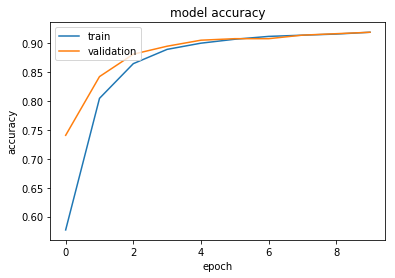

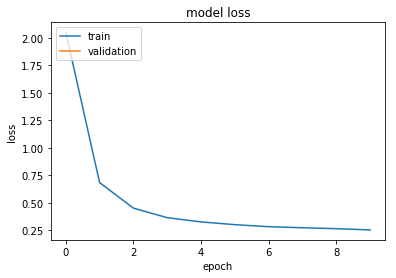

new jersey est parfois calme en l' et et il est neigeux neigeux avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [136]:
visualize_train(hist)

# Print prediction(s)
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

In [138]:
from keras.layers import Bidirectional

def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    
    ref: https://keras.io/layers/wrappers/
    ref: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
    
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # hyperparams
    hidden_dim = 64
    learning_rate = 0.01
    
    # model
    model_input = Input(shape=(input_shape[1], input_shape[2]))
    bidir_rnn_layer = Bidirectional(GRU(hidden_dim, return_sequences=True))
    rnn_outputs = bidir_rnn_layer(model_input)
    tdddense_layer = TimeDistributed(Dense(french_vocab_size, activation='softmax'))
    model_output = tdddense_layer(rnn_outputs)
    model = Model(model_input, model_output)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_bd_model(bd_model)

In [139]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
bd_rnn_model = bd_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index),
    len(french_tokenizer.word_index))

bd_rnn_model.summary()

hist = bd_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        (None, 21, 1)             0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 21, 128)           25344     
_________________________________________________________________
time_distributed_78 (TimeDis (None, 21, 344)           44376     
Total params: 69,720
Trainable params: 69,720
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 13s - loss: 1.8584 - acc: 0.5777 - val_loss: nan - val_acc: 0.6422
Epoch 2/10
110288/110288 [==============================] - 9s - loss: 1.2227 - acc: 0.6548 - val_loss: nan - val_acc: 0.6646
Epoch 3/10
110288/110288 [==============================] - 9s - loss: 1.1004 - acc: 0.6721 - val_

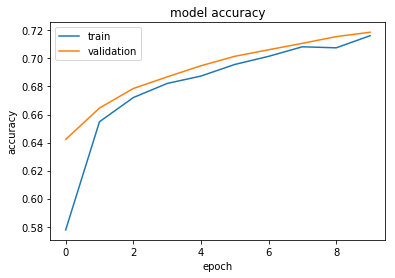

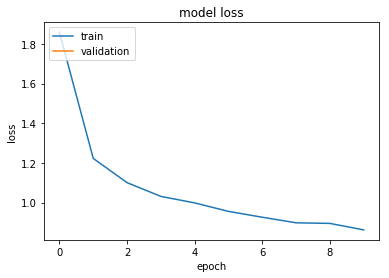

new jersey est parfois chaud en mois de mai et il il en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [140]:
visualize_train(hist)

# Print prediction(s)
print(logits_to_text(bd_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [141]:
from keras.layers import RepeatVector

def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # ref: https://github.com/keras-team/keras/issues/5203
    rnn_dim = 64
    learning_rate = 0.01
    
    # ENCODER
    enc_model_input = Input(shape=(input_shape[1], input_shape[2]))
    enc_rnn_layer = GRU(rnn_dim, return_state=True)
    encoded, enc_state = enc_rnn_layer(enc_model_input)
    repeat = RepeatVector(output_sequence_length)
    dec_input = repeat(encoded)
    
    # DECODER
    dec_rnn_layer = GRU(rnn_dim, return_state=True, return_sequences=True)
    dec_output, _ = dec_rnn_layer(dec_input, initial_state=enc_state)
    dec_tddense = TimeDistributed(Dense(french_vocab_size, activation='softmax'))
    dec_output = dec_tddense(dec_output)
    model = Model(enc_model_input, dec_output)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_encdec_model(encdec_model)

In [142]:
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index),
    len(french_tokenizer.word_index))

encdec_rnn_model.summary()

hist = encdec_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, epochs=10, validation_split=0.2)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_90 (InputLayer)            (None, 21, 1)         0                                            
____________________________________________________________________________________________________
gru_108 (GRU)                    [(None, 64), (None, 6 12672       input_90[0][0]                   
____________________________________________________________________________________________________
repeat_vector_12 (RepeatVector)  (None, 21, 64)        0           gru_108[0][0]                    
____________________________________________________________________________________________________
gru_109 (GRU)                    [(None, 21, 64), (Non 24768       repeat_vector_12[0][0]           
                                                                   gru_108[0][1]           

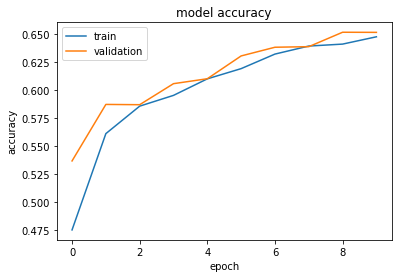

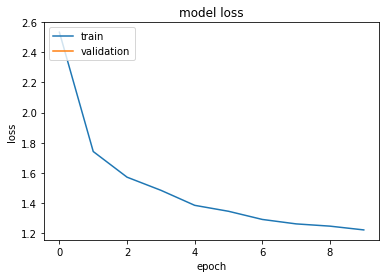

new jersey est généralement agréable en mois et il est est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [144]:
visualize_train(hist)

# Print prediction(s)
print(logits_to_text(encdec_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [145]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # hyperparams: 
    embed_dim = 100
    rnn_dim = 64
    learning_rate = 0.01
    
    # model
    model_input = Input(shape=(input_shape[1],))
    embedding_layer = Embedding(english_vocab_size, embed_dim, input_length=output_sequence_length)
    rnn_input = embedding_layer(model_input)
    rnn_layer = Bidirectional(GRU(rnn_dim, return_sequences=True))
    rnn_outputs = rnn_layer(rnn_input)
    tddense_layer = TimeDistributed(Dense(french_vocab_size, activation='softmax'))
    output = tddense_layer(rnn_outputs)
    model = Model(model_input, output)
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_model_final(model_final)

print('Final Model Loaded')

Final Model Loaded


## Prediction (IMPLEMENTATION)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 21, 100)           19900     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 21, 128)           63360     
_________________________________________________________________
time_distributed_83 (TimeDis (None, 21, 344)           44376     
Total params: 127,636
Trainable params: 127,636
Non-trainable params: 0
_________________________________________________________________
Train on 110288 samples, validate on 27573 samples
Epoch 1/10
110288/110288 [==============================] - 14s - loss: 1.5050 - acc: 0.6610 - val_loss: nan - val_acc: 0.8269
Epoch 2/10
110288/110288 [==============================] - 11s - loss: 0.4108 - acc: 0.87

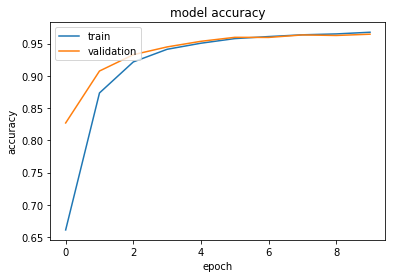

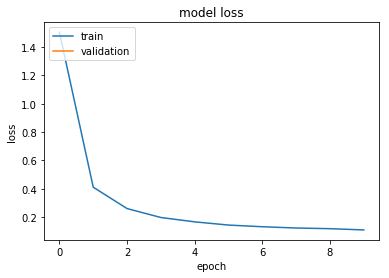

ValueError: Error when checking : expected input_93 to have shape (None, 21) but got array with shape (2, 15)

In [148]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences


def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    
    # TODO: Train neural network using model_final
    
    tmp_x = pad(x, y.shape[1])
    tmp_x = tmp_x.reshape((-1, y.shape[-2]))
    
    model = model_final(
                tmp_x.shape,
                y.shape[1],
                len(x_tk.word_index),
                len(y_tk.word_index))
    model.summary()
    
    hist = model.fit(tmp_x, y, batch_size=1024, epochs=10, validation_split=0.2)
    visualize_train(hist)
    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.argmax(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

## Submission
When you are ready to submit your project, do the following steps:
1. Ensure you pass all points on the [rubric](https://review.udacity.com/#!/rubrics/1004/view).
2. Submit the following in a zip file.
  - `helper.py`
  - `machine_translation.ipynb`
  - `machine_translation.html`
    - You can export the notebook by navigating to **File -> Download as -> HTML (.html)**.